## Unsupervised Learning for Cyberbullying Tweets

In the modern age, social media has taken the world by storm and can be beneficial but also dangerous at the same time. This is evident by the rising instances of cyberbullying, an important issue that requires monitoring with machine learning. This project aims to analyze a large dataset of tweets that are classified into different types of cyberbullying (or non-cyberbullying) using **unsupervised learning** techniques. The primary objective is to use *clustering* and *matrix factorization* to model topics and discover interesting observations hidden in the data structure. While the goal in unsupervised learning is not to directly predict tweet classifications, this approach will help us gain insights into grouping together subsets of these tweets based on similarity and identify some trends along the way.

### Data Source
Maranhao, A. (2021, January) Cyberbullying Classification. Retrieved from https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/datata. 

The source of the data is supplied by an open-source dataset from Kaggle.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# import data
data = pd.read_csv('data/cyberbullying_tweets.csv')
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [3]:
data.info()
print(f'Number of observations: {data.shape[0]}, number of features: {data.shape[1]}') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB
Number of observations: 47692, number of features: 2


### Data Cleaning

From an initial overview of the data, we can see that the dataset contains quite a large number of observations (47692) and only two columns: one consisting of the tweet text and one to classify the tweet. The labeling will not be helpful for unsupervised learning, but it can come into play later when comparing the subgroups created by the unsupervised model.

The first idea for cleaning is to ensure there are no rows in the dataset with empty tweets as these will provide no value for learning. Unlike datasets with numeric columns, there is no clear way to impute values for these empty rows (if there are any) so they will be removed as the first step. In addition to this, any duplicate row should be removed as well since that can be a common mistake in a larger dataset.

In [4]:
# remove rows with empty tweet text (use subset)
data_clean = data.dropna(subset=['tweet_text'])

# remove rows that are duplicates (keep the first instance by default)
data_clean = data_clean.drop_duplicates(subset=['tweet_text'])

data_clean.shape

(46017, 2)

Notice that there were 1600+ observations dropped from these restrictions which is a good sign that the cleanup step was needed to avoid running into future issues. The next step for data cleaning that will be taken is removing all hashtags and mentions from tweets. For some context, a hashtag in a tweet begins with the '#' symbol and is used to identify a topic while a mention in a tweet begins with the '@' symbol is used to tag another user. Certainly, mentions do not hold much meaning in messages, and while hashtag topics are more debatable, it can just become additional noise when it comes to analysis as it is preferable to deal with clean text data.

In [5]:
# remove all hashtag and mention strings from each tweet_text
def clean_text(txt):
    # assume proper spacing + remove any case sensitivity
    words = [word.lower() for word in txt.split() if word[0] != '@' and word[0] != '#']
    return ' '.join(words)

data_clean['tweet_text'] = data_clean['tweet_text'].map(clean_text)

The final cleaning step will be to transform all categorical classification data to numerical. While this is not essential to running unsupervised models, if the labels are needed post-model for analysis, it will only hold value in a numerical format in order to draw comparisons against the same data types. To ensure there is still access to the actual string labels themselves, a new column will be created to store the encoded categories. 

In [6]:
# get classification labels and assign each an integer
labels = data_clean['cyberbullying_type'].unique()
encoding = {label: idx for idx, label in enumerate(labels)}

# create mapping from index values back to str (for plotting axis probably)
label_str_mapping = {idx: label for label, idx in encoding.items()}

# encode labels to integer
data_clean['cyberbullying_encoded'] = data_clean['cyberbullying_type'].map(encoding)

print(label_str_mapping)

{0: 'not_cyberbullying', 1: 'gender', 2: 'religion', 3: 'other_cyberbullying', 4: 'age', 5: 'ethnicity'}


Now we are done with the data cleaning process, before moving on to EDA let's take a look at the cleaned dataset:

In [7]:
data_clean.head(10)

,tweet_text,cyberbullying_type,cyberbullying_encoded
0,in other words your food was crapilicious!,not_cyberbullying,0
1,why is so white?,not_cyberbullying,0
2,a classy whore? or more red velvet cupcakes?,not_cyberbullying,0
3,"meh. :p thanks for the heads up, but not too c...",not_cyberbullying,0
4,this is an isis account pretending to be a kur...,not_cyberbullying,0
5,"yes, the test of god is that good or bad or in...",not_cyberbullying,0
6,itu sekolah ya bukan tempat bully! ga jauh kay...,not_cyberbullying,0
7,karma. i hope it bites kat on the butt. she is...,not_cyberbullying,0
8,everything but mostly my priest,not_cyberbullying,0
9,rebecca black drops out of school due to bully...,not_cyberbullying,0


### Exploratory Data Analysis

Since there is no feature correlation in this type of dataset, we will instead display a count of tweet classification labels. This is a common step to take in classification datasets as some models will suffer from having a heavily skewed class distribution. In particular, this is especially important for *supervised learning* models as they are required to make optimal predictions, requiring additional resampling steps to be taken if it is an issue.

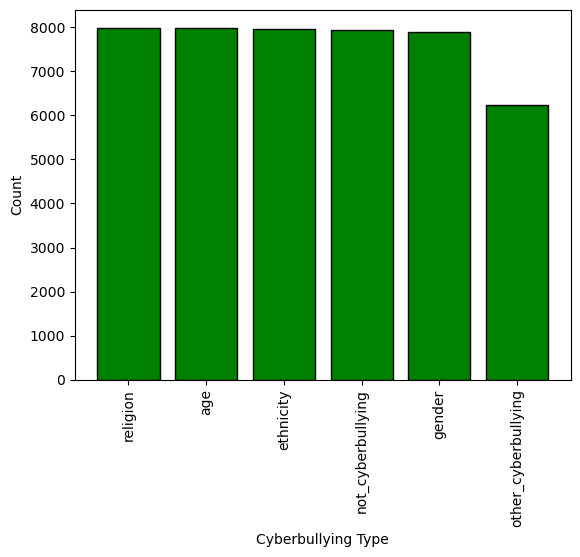

In [8]:
# plot classification distribution count
class_counts = data_clean['cyberbullying_type'].value_counts()
plt.bar(class_counts.index, class_counts.values, color='green', edgecolor='black')
plt.xlabel('Cyberbullying Type')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()
# print(class_counts.index, class_counts.values)

Looking at this distribution, the dataset is seemingly well balanced which is a great property to have for the data.

For sensitivity purposes, I will refrain from visualizing information surrounding things like most commonly used words in tweets, but feel free to inspect the data source on your own. Now, let's move to the most important part of EDA which is a mandatory step needed for learning and that is word embedding. This is to transform all text data into numerical features that will be useful for clustering and matrix factorization methods. The word embedding method that will be used here is TF-IDF. As a summary, TF-IDF vectorizes term frequency and inverse document frequency (word significance) and multiply these together to obtain a matrix with values grading the importantance of a word. Here is an excellent resource on the topic: https://www.kaggle.com/code/paulrohan2020/tf-idf-tutorial. TF-IDF is implemented below:

In [9]:
# TF-IDF word embedding (similar to week 4)
vectorizer = TfidfVectorizer()

# transform tweets data
tweets_feats_mat = vectorizer.fit_transform(data_clean['tweet_text'])
print(tweets_feats_mat.shape)

(46017, 44825)


In [10]:
# extract 10 non-zero samples to print out
row_idxs, col_idxs = np.nonzero(tweets_feats_mat.toarray())
row_idxs, col_idxs = row_idxs[:10], col_idxs[:10]
samples = [(i, j, tweets_feats_mat[i, j]) for i, j in zip(row_idxs, col_idxs)]
# get words (features)
feats_names = vectorizer.get_feature_names_out()

print("Some examples of TF-IDF feature entries:")
for i, j, value in samples:
    print(f'Document (tweet) {i}, Feature (word) "{feats_names[j]}": {value:.2f}')

Some examples of TF-IDF feature entries:
Document (tweet) 0, Feature (word) "crapilicious": 0.69
Document (tweet) 0, Feature (word) "food": 0.43
Document (tweet) 0, Feature (word) "in": 0.15
Document (tweet) 0, Feature (word) "other": 0.29
Document (tweet) 0, Feature (word) "was": 0.20
Document (tweet) 0, Feature (word) "words": 0.38
Document (tweet) 0, Feature (word) "your": 0.22
Document (tweet) 1, Feature (word) "is": 0.34
Document (tweet) 1, Feature (word) "so": 0.46
Document (tweet) 1, Feature (word) "white": 0.58


Some of the TF-IDF matrix features are printed out above to obtain an understanding of how the transformed values look. In the word-embedded matrix, the original tweets each correspond to a row and each column is a word/feature in that original tweet. The score of each feature measures the importance of the term, so in this case "in" would be the least significant word relative to the other features printed.

This will conclude the exploratory data analysis, having performed data cleaning and TF-IDF word embedding as the two most critical processes in this section. Now, we can move on to constructing the unsupervised learning models.

### Unsupervised Learning Models

The two models that will be implemented will feature clustering and matrix factorization on topics. In particular, KMeans will be used for clustering as it is a logical choice for grouping together data based on their feature significance from the word-embedded matrix. The model should be effective for visualization purposes as well. On the other hand, matrix factorization is a great way to decompose the word-embedded matrix to model document topics that are prevalent across different tweets. It is also very complementary when combined with clustering for us to develop a full picture of the data as the goal of the project. 

So that was an overview of the logic behind the unsupervised learning model choices. Let's get started with implementing clustering with K-means.

[0 0 0 ... 4 4 4] (46017,)


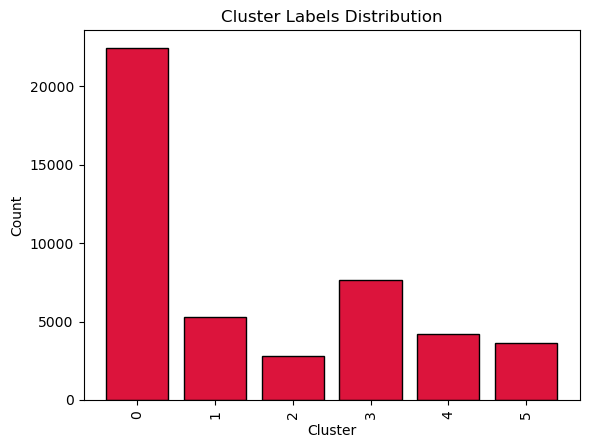

In [13]:
# choose k = 6 since there are that many tweet classifications
kmeans_model = KMeans(n_clusters=6, random_state=42)
kmeans_model.fit(tweets_feats_mat)

# find clusters
clusters_labels = kmeans_model.labels_
print(clusters_labels, clusters_labels.shape)

# get cluster counts
cluster_counts = {}
for cluster in clusters_labels:
    cluster_counts[cluster] = cluster_counts.get(cluster, 0) + 1

# plot cluster labelling distribution 
plt.bar(cluster_counts.keys(), cluster_counts.values(), color='crimson', edgecolor='black')
plt.title('Cluster Labels Distribution')
plt.xlabel('Cluster')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

(46017, 44825)


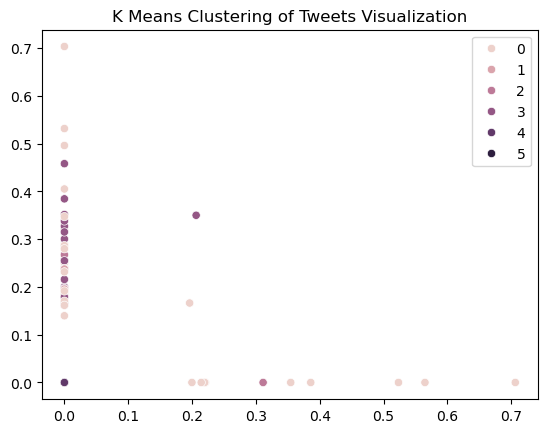

In [14]:
# plot the clusters
tweets_feats = tweets_feats_mat.toarray()
print(tweets_feats.shape)
sns.scatterplot(x=tweets_feats[:, 0], y=tweets_feats[:, 1], hue=clusters_labels)
plt.title('K Means Clustering of Tweets Visualization')
plt.show()

**Clusters Distribution**

In the EDA section we were able to see a fairly well balanced distribution of cyberbullying tweet classifications, with the exception of "other cyberbullying" having reduced counts. After running the clustering model on the embedded feature data, 5 out of 6 types of cyberbullying classes have similar counts, with the first cluster group labelled by 0 being by far the dominant group in terms of numbers. There is nothing wrong with this, as unsupervised learning does not use labels for training. Instead, this suggests that a large portion of the tweets in dataset have some similar characteristics and patterns underlying in the data that would create groups in this formation based off similarity metrics. For example, one justification could be that many of the tweets share common words in the English dictionary that individually would not be deemed offensive, and thus are more likely to be clustered together, forming a larger group of "not cyberbullying" tweets. 

Of course, it is difficult to dive into deeper analysis on the intricacies of the tweet text without attempting advanced natural language processing models which are outside the scope of the project analyzing behavior of unsupervised models, but that would be an interesting side project to consider in the future.

**Clustering Plot**

The scatter plot attempts to visualize tweet matrix features while highlighting formed clusters in a 2D setting. However, there is not much to gain from this visual as most of the original feature scores were very close to each other. Instead, an idea to enhance the visualization is to use one of the first tricks introduced in the course, by reducing dimensionality of the feature matrix and then re-creating the visualization.

(46017, 2)


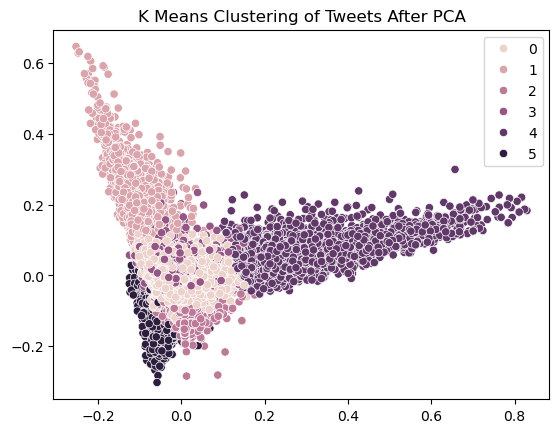

In [15]:
# reduce dimensionality with PCA transformation
pca = PCA(n_components=2)
tweets_reduced = pca.fit_transform(tweets_feats)
print(tweets_reduced.shape)

sns.scatterplot(x=tweets_reduced[:, 0], y=tweets_reduced[:, 1], hue=clusters_labels)
plt.title('K Means Clustering of Tweets After PCA')
plt.show()

A pretty interesting visual and much more interpretable in terms of identifying clusters of tweets. The demonstration of PCA being a powerful tool as an intermediate step in unsupervised models is on display. Before moving on, let's briefly calculate how clustering performed by making use of the original labels in the dataset. Keep in mind we should not be expecting a highly accurate performance, as seen from the imbalanced cluster distribution earlier.

In [16]:
# compare cluster modeling to original labels
import itertools

# helper function from previous lab to find best permutation order of labels
def label_permute_compare(ytdf, yp, n=6):
    """
    Returns permuted label order and accuracy. 
    """
    # your code here
    label_order = []
    acc = 0
    # iterate through all possible permutations of labels
    for mapping in itertools.permutations(range(n)):
        # mapping new label order onto clusters
        mapped_labels = [mapping[old_label] for old_label in yp]
        
        # compute accuracy
        cur_acc = accuracy_score(ytdf, mapped_labels)
        if (cur_acc > acc):
            acc = cur_acc
            label_order = mapping
    return label_order, acc

# obtain accuracy, map clusters to align with data and show confusion matrix
tweet_labels = data_clean['cyberbullying_encoded']
labelorder, acc = label_permute_compare(tweet_labels, clusters_labels)
true_clusters = [labelorder[cluster] for cluster in clusters_labels]

print(f'Clustering Accuracy: {acc}')
confusion_matrix(tweet_labels, true_clusters)

Clustering Accuracy: 0.5205902166590608


array([[6066,    7,  804,  990,   59,   11],
       [3202, 3617,  706,  353,    9,   11],
       [3713,    2, 3925,  348,    6,    1],
       [4474,    6,  681, 1026,   46,   10],
       [2127,    5,  673,    7, 5177,    3],
       [2883,    4,  863,   47,   10, 4145]], dtype=int64)

As expected, we do not get a great accuracy when comparing cluster labels back to the labels in the dataset. However, the confusion matrix shows interesting results. There are some cyberbullying groups that have a great classification rate by nearly capturing all of the true positive cases, but notably the first KMeans cluster group is responsible for a large percentage of the errors. A possible interpretation of the results would be: while most of the original *non-cyberbullying* tweets were classified correctly, a high portion of other types of *cyberbullying* tweets were wrongly classified as *non-cyberbullying*. One justification behind this is due to the similarities shared by words in their feature score evaluations, used in both form of tweet texts. This also gives provides some evidence for the earlier theory of overclassifying "not cyberbullying" labels in the first cluster.

Tuning parameters or using cross-validation is not very applicable here, as there is not a lot to gain from trying to improve model performance since classification is not one of the unsupervised model's learning goals. 

Using a combination of all of the techniques thus far ties nicely into what we have learned in the course, and that will now be transitioned into using matrix factorization as a different method to factor the word-embedded matrix into two separate matrices and extract latent features from modelling document topics. 

In [18]:
# build model using NMF
nmf_model = NMF(n_components=6, random_state=42)
W = nmf_model.fit_transform(tweets_feats_mat)
H = nmf_model.components_
print(W.shape, H.shape)

(46017, 6) (6, 44825)


The tweet features matrix is factored into W x H where W is (# of documents/tweets x # of components/topics) and H is (# of components/topics x # of features/words). With the matrix factorization model constructed, let's view each factored component in more detail with some visuals:

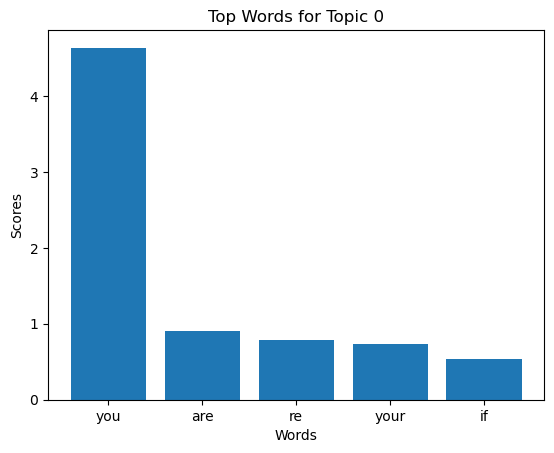

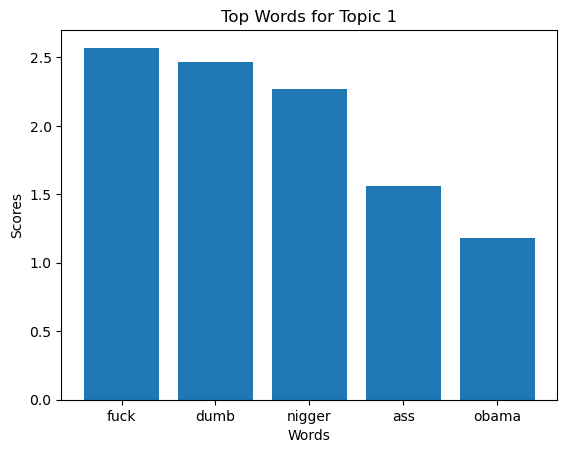

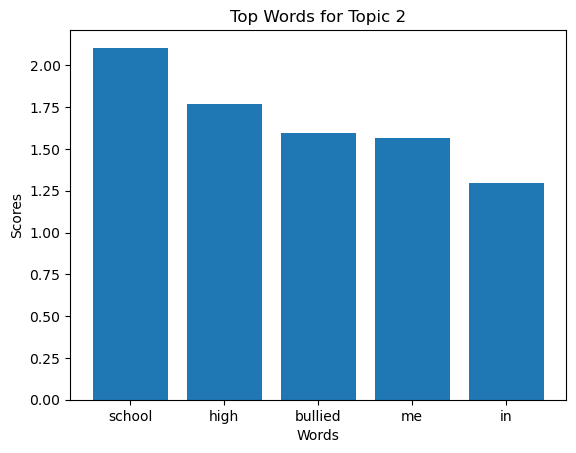

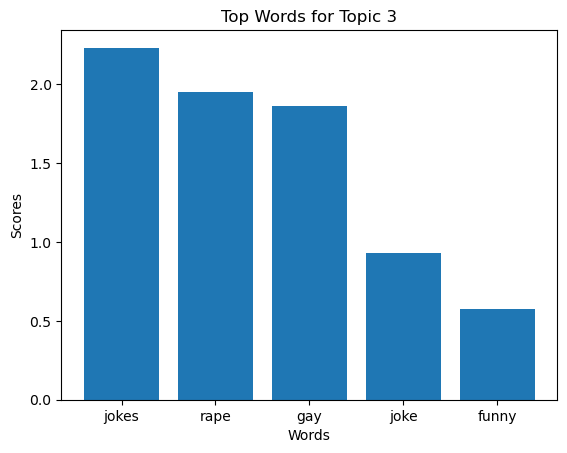

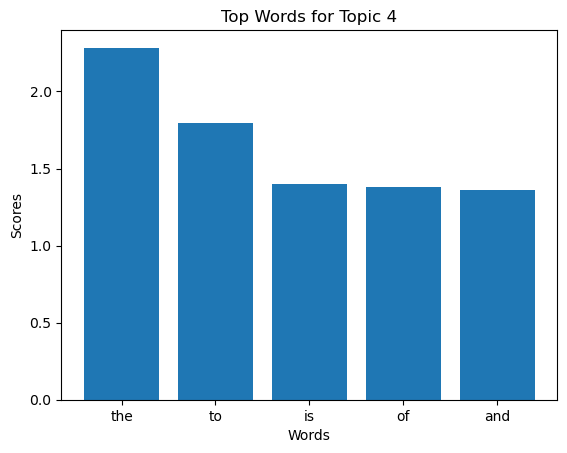

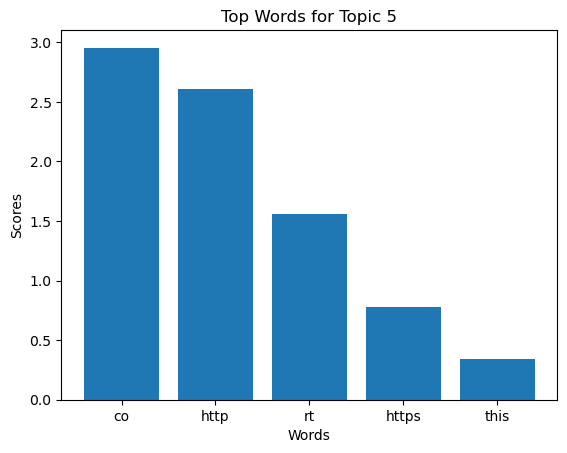

In [19]:
# plot the top words for each document topic
top_n = 5
for idx, topic in enumerate(H):
    # find indices of top 5 words of each factored topic
    top_idxs = topic.argsort()[::-1][:top_n]
    top_scores = topic[top_idxs]
    top_words = [feats_names[i] for i in top_idxs]

    # plot top words
    plt.bar(top_words, top_scores)
    plt.title(f'Top Words for Topic {idx}')
    plt.xlabel('Words')
    plt.ylabel('Scores')
    plt.show()

Apologies if any of the words in the dataset are at all offensive since this is a sensitive subject. The visualizations correspond to the second factored matrix, representing the topics in the document. The graphs are made to get an intuition on which word features contribute most significantly to each topic, which we will now use to make some general classifications based on the highest scoring topic for each tweet in the W matrix.

{2: 7811, 4: 19793, 5: 4030, 0: 5414, 1: 4979, 3: 3990}


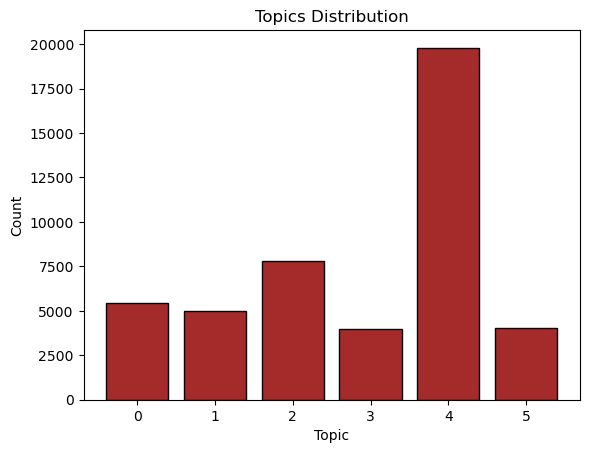

In [20]:
# get top topic for each tweet
top_topics = [np.argmax(W[i]) for i in range(W.shape[0])]
# print(top_topics)

# plot distribution of top topics over each tweet
topic_counts = {}
for topic in top_topics:
    topic_counts[topic] = topic_counts.get(topic, 0) + 1
print(topic_counts)

# plot cluster labelling distribution 
plt.bar(topic_counts.keys(), topic_counts.values(), color='brown', edgecolor='black')
plt.title('Topics Distribution')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.show()

By taking the top scoring topics on each document, the above distribution of classified topics is shown. Connecting the visualizations of both factored components, we can see that for topic 4 which contains the most classifications, there are many common English words such as 'the', 'to', 'is', etc. Based on the popularity of these words in text, it is not surprising to see topic 4 become the dominant weighted topic for a high volume of tweets. It highlights a problem with the current model, as these popular terms are more well-known as **stopwords** in traditional NLP tasks. Unfortunately, for our purposes generating an exhaustive list of stopwords is quite the strenuous task more suited for a NLP-based project, but it is a plus to identify an issue underlying in the text data that would have gone unnoticed without analyzing the models. 

Although not practical, here is a sample prediction rate of using topic modelling as a classifier based on the original tweet labels.

In [21]:
# get predictions and align with original data and show confusion matrix
nmf_labelorder, nmf_acc = label_permute_compare(tweet_labels, top_topics)
true_topics = [nmf_labelorder[topic] for topic in top_topics]

print(f'Matrix Factorization Accuracy: {nmf_acc}')
confusion_matrix(tweet_labels, true_topics)

Matrix Factorization Accuracy: 0.4906012995197427


array([[1619,   78, 4263,  983,  863,  131],
       [ 682, 3791, 2413,  719,  199,   94],
       [ 394,   17, 5690, 1850,   39,    5],
       [1235,   77, 3201,  915,  668,  147],
       [  13,   16, 1579,  393, 5975,   16],
       [  87,   11, 2647,  554,   67, 4586]], dtype=int64)

Clearly, the number of misclassifications correspond mainly to topic 4. Performing classification based on top-weighted topics in this situation will fail to produce good results in terms of predictions and highlights the fact that NLP techniques or supervised learning models is a better choice if we only cared about accuracy performance. Instead, conducting matrix factorization helped us identify important text patterns that resided in the dataset.

However, just as a quick comparison with supervised models that are revolved around making correct predictions, let's build and train a quick logistic regression model to see if it can make better classifications on the dataset.

In [22]:
# split tweets data into train-test
X_train, X_test, y_train, y_test = train_test_split(tweets_feats_mat, tweet_labels, test_size=0.2, random_state=42)
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# get predictions
log_preds = log_model.predict(X_test)
log_acc = accuracy_score(y_test, log_preds)
print(f'Logistic Regression Tweet Cyberbullying Classification Accuracy: {log_acc}')

Logistic Regression Tweet Cyberbullying Classification Accuracy: 0.8292046936114733


Even a generic supervised learning model does not show great classification performance but nonetheless is a substantial improvement over unsupervised learning models as it uses the true labels for training. The performance of the logistic model has  much room for improvement, demonstrating the complexity behind large text-based datasets and hints that further refinements (e.g. additional pre-processing step to correctly weigh word terms) can be made to optimize the data for higher success.

### Conclusion

**Takeaways/Learnings**

One of the primary lessons that I learned from the analysis of the NMF model was the impact of English stopwords ("the", "is", etc.) can have. Having a more sophisticated text-cleaning approach (see below) is required in order to refine the dataset for classification, and this issue likely impacted the supervised learning model as well. A combination of clustering and matrix factorization techniques helped us uncover these patterns in the data that would have been unknown otherwise, so the unsupervised learning was effective in its goals to break down the data structure. Finally, principal component analysis was key to enable clear visualizations of clustering results and is a powerful preprocessing step in unsupervised models.

**What Failed**

Due to the reasons above and in the model analysis, the reality is neither clustering nor NMF models are a viable approach for classifying tweets. The objective of the report was not to optimize performance so this is fine, but the low accuracy exposes limitations in both the dataset and in the models. 

**Next Steps**

There are many possible next steps that I can identify after concluding the project. Moving forward, an NLP-based approach can be considered leveraging sentiment analysis, transformer models and more advanced language-based techniques which will be more effective as a true text classification project. In addition, applying text cleaning techniques such as lemmatization will more accurately measure the influence of each individual word and help resolve issues encountered here with stopwords. 

That concludes this project using unsupervised learning to analyze cyberbullying tweets. Thank you for reading.